In [1]:
%%capture
!pip install torch tqdm matplotlib scikit-learn

In [2]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from cca_zoo.linear import CCA
from cca_zoo.deep import architectures, DCCA
from cca_zoo.data.deep import NumpyDataset, check_dataset, get_dataloaders
import pytorch_lightning as pl

## Plotting Code

### Clustering using t-SNE

In [3]:
def save_activation_projection_tsne(
    split1_activations1,
    split1_activations2,
    split2_activations1,
    split2_activations2,
    fname,
    title,
    split1_label1="Split 1 Positive Examples",
    split1_label2="Split 1 Negative Examples",
    split2_label1="Split 2 Positive Examples",
    split2_label2="Split 2 Negative Examples",
):
    """
    split1_activations1: n_samples x vector dim tensor
    split1_activations2: n_samples x vector dim tensor
    split2_activations1: n_samples x vector dim tensor
    split2_activations2: n_samples x vector dim tensor

    projects to n_samples x 2 dim tensor using t-SNE (over the full dataset of both activations 1 and 2) and saves visualization.
    Colors projected activations1 as blue and projected activations2 as red for the first split.
    Colors projected activations1 as green and projected activations2 as orange for the second split.
    """
    plt.clf()
    activations = torch.cat([split1_activations1, split1_activations2, split2_activations1, split2_activations2], dim=0)
    activations_np = activations.cpu().numpy()

    # t-SNE transformation
    tsne = TSNE(n_components=2)
    projected_activations = tsne.fit_transform(activations_np)

    # Getting back activations1 and activations2 for both splits
    indices = [
        (0, split1_activations1.shape[0]),
        (split1_activations1.shape[0], split1_activations1.shape[0] + split1_activations2.shape[0]),
        (split1_activations1.shape[0] + split1_activations2.shape[0], split1_activations1.shape[0] + split1_activations2.shape[0] + split2_activations1.shape[0]),
        (split1_activations1.shape[0] + split1_activations2.shape[0] + split2_activations1.shape[0], None)
    ]
    split1_activations1_projected = projected_activations[indices[0][0]: indices[0][1]]
    split1_activations2_projected = projected_activations[indices[1][0]: indices[1][1]]
    split2_activations1_projected = projected_activations[indices[2][0]: indices[2][1]]
    split2_activations2_projected = projected_activations[indices[3][0]: indices[3][1]]

    # Visualization for split 1
    for x, y in split1_activations1_projected:
        plt.scatter(x, y, color="blue", marker="o", alpha=0.4)

    for x, y in split1_activations2_projected:
        plt.scatter(x, y, color="red", marker="o", alpha=0.4)
        
    # Visualization for split 2
    for x, y in split2_activations1_projected:
        plt.scatter(x, y, color="green", marker="s", alpha=0.4)

    for x, y in split2_activations2_projected:
        plt.scatter(x, y, color="orange", marker="s", alpha=0.4)

    # Adding the legend
    split1_scatter1 = plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="blue",
        markersize=10,
        label=split1_label1,
    )
    split1_scatter2 = plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="red",
        markersize=10,
        label=split1_label2,
    )
    
    split2_scatter1 = plt.Line2D(
        [0],
        [0],
        marker="s",
        color="w",
        markerfacecolor="green",
        markersize=10,
        label=split2_label1,
    )
    split2_scatter2 = plt.Line2D(
        [0],
        [0],
        marker="s",
        color="w",
        markerfacecolor="orange",
        markersize=10,
        label=split2_label2,
    )

    plt.legend(handles=[split1_scatter1, split1_scatter2, split2_scatter1, split2_scatter2])
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.savefig(fname)

In [4]:
def plot_all_activations(dirpath1, dirpath2, layers):
    if not os.path.exists("../save"):
        os.mkdir("../save")
        
    for layer in layers:
        first_pos = torch.load(f"{dirpath1}/positive_layer_{layer}.pt")
        first_neg = torch.load(f"{dirpath1}/negative_layer_{layer}.pt")
        second_pos = torch.load(f"{dirpath2}/positive_layer_{layer}.pt")
        second_neg = torch.load(f"{dirpath2}/negative_layer_{layer}.pt")
        
        # reduce dimensionality using PCA
        pca_dim = min(first_pos.shape[0] + first_neg.shape[0],
                      second_pos.shape[0] + second_neg.shape[0])
        
        first_pca = PCA(n_components=pca_dim)
        first_pca.fit(torch.cat([first_pos, first_neg], dim=0))
        first_pos = torch.tensor(first_pca.transform(first_pos))
        first_neg = torch.tensor(first_pca.transform(first_neg))
        
        second_pca = PCA(n_components=pca_dim)
        second_pca.fit(torch.cat([second_pos, second_neg], dim=0))
        second_pos = torch.tensor(second_pca.transform(second_pos))
        second_neg = torch.tensor(second_pca.transform(second_neg))
        
        save_activation_projection_tsne(
            first_pos,
            first_neg,
            second_pos,
            second_neg,
            f"../save/activations_layer_{layer}.png",
            f"t-SNE projected activations layer {layer}",
            split1_label1="Split 1 Positive Examples",
            split1_label2="Split 1 Negative Examples",
            split2_label1="Split 2 Positive Examples",
            split2_label2="Split 2 Negative Examples"
        )

### Cosine Similarity

In [5]:
def plot_all_cosine_similarity(dirpath1, dirpath2, layers):
    # Stacking all steering vectors
    split1_vec_list, split2_vec_list = [], []
    for layer in layers:
        split1_vec = torch.load(f"{dirpath1}/vec_layer_{layer}.pt")
        split1_vec_list.append(split1_vec)    
        split2_vec = torch.load(f"{dirpath2}/vec_layer_{layer}.pt")
        split2_vec_list.append(split2_vec)
        
    # reduce dimensionality
    dim = min(len(split1_vec_list), len(split2_vec_list))
    split1_pca = PCA(n_components=dim)
    split1_vec_list = [torch.tensor(t) for t in split1_pca.fit_transform(split1_vec_list)]
    split2_pca = PCA(n_components=dim)
    split2_vec_list = [torch.tensor(t) for t in split2_pca.fit_transform(split2_vec_list)]
        
    # Computing cosine similarity for each pair
    all_split1_vec = torch.stack(split1_vec_list).unsqueeze(1)
    all_split2_vec = torch.stack(split2_vec_list).unsqueeze(1)
    cosine_sim = F.cosine_similarity(all_split1_vec, all_split2_vec, dim=2).tolist()
    
    # Visualization 
    plt.plot(layers, cosine_sim, marker='o')
    
    plt.title(f"Cosine Similarity of Steering Vectors vs Layer Number\nSplit 1: {dirpath1}\nSplit 2: {dirpath2}")
    plt.xlabel("Layer Number")
    plt.ylabel("Cosine Similarity")
    plt.ylim([-1.05, 1.05])
    plt.tight_layout()
    plt.savefig("../save/cosine_similarity_vs_layer.png")

### CCA 

In [6]:
def plot_all_cca_values(dirpath1, dirpath2, layers):
    # Learning common subspace for activation vectors using CCA
    layer_cca_list = []
    for layer in layers:
        print("CCA for layer:", layer)
        first_activations = torch.cat([torch.load(f"{dirpath1}/positive_layer_{layer}.pt"),
                                       torch.load(f"{dirpath1}/negative_layer_{layer}.pt")])
        second_activations = torch.cat([torch.load(f"{dirpath2}/positive_layer_{layer}.pt"),
                                        torch.load(f"{dirpath2}/negative_layer_{layer}.pt")])
        dim = min(first_activations.shape[1], second_activations.shape[1], 100)
        cca = CCA(dim)
        cca.fit([first_activations.numpy(), second_activations.numpy()])
        layer_cca_list.append(cca)
        
    # Transforming steering vectors into learnt subspace
    split1_vec_list, split2_vec_list = [], []
    for layer in layers:
        split1_vec = torch.load(f"{dirpath1}/vec_layer_{layer}.pt")
        split2_vec = torch.load(f"{dirpath2}/vec_layer_{layer}.pt")
        
        cca = layer_cca_list[layer]
        cca_split1_vec, cca_split2_vec = cca.transform([split1_vec, split2_vec])
        split1_vec_list.append(cca_split1_vec)
        split2_vec_list.append(cca_split2_vec)
        
    # Computing cosine similarity for each pair
    all_split1_vec = torch.stack(split1_vec_list).unsqueeze(1)
    all_split2_vec = torch.stack(split2_vec_list).unsqueeze(1)
    cosine_sim = F.cosine_similarity(all_split1_vec, all_split2_vec, dim=2).tolist()
    
    # Visualization 
    plt.plot(layers, cosine_sim, marker='o')
    
    plt.title(f"Cosine Similarity of CCA Steering Vectors vs Layer Number\nSplit 1: {dirpath1}\nSplit 2: {dirpath2}")
    plt.xlabel("Layer Number")
    plt.ylabel("Cosine Similarity")
    plt.ylim([-1.05, 1.05])
    plt.tight_layout()
    plt.savefig("../save/cca_cosine_similarity_vs_layer.png")

### DCCA

In [7]:
def plot_all_dcca_values(dirpath1, dirpath2, layers):
    # Learning common subspace for activation vectors using DCCA
    layer_dcca_list = []
    for layer in layers:
        print("DCCA for layer:", layer)
        first_activations = torch.cat([torch.load(f"{dirpath1}/positive_layer_{layer}.pt"),
                                       torch.load(f"{dirpath1}/negative_layer_{layer}.pt")])
        second_activations = torch.cat([torch.load(f"{dirpath2}/positive_layer_{layer}.pt"),
                                        torch.load(f"{dirpath2}/negative_layer_{layer}.pt")])
        
        assert np.isnan(first_activations).any() == False
        assert np.isnan(second_activations).any() == False
        
        # Define DCCA model
        dim = min(first_activations.shape[1], second_activations.shape[1], 25)
        first_encoder = architectures.Encoder(latent_dimensions=dim, feature_size=first_activations.shape[1])
        second_encoder = architectures.Encoder(latent_dimensions=dim, feature_size=second_activations.shape[1])
        dcca_model = DCCA(latent_dimensions=dim, encoders=[first_encoder, second_encoder])
        
        # Train DCCA model
        first_activations_train_dataset, first_activations_val_dataset = train_test_split(first_activations.numpy(), 
                                                                                          test_size=0.33,
                                                                                          shuffle=True)
        second_activations_train_dataset, second_activations_val_dataset = train_test_split(second_activations.numpy(), 
                                                                                            test_size=0.33,
                                                                                            shuffle=True)
        activations_train_dataset = NumpyDataset([first_activations_train_dataset, second_activations_train_dataset])
        activations_val_dataset = NumpyDataset([first_activations_val_dataset, second_activations_val_dataset])
        train_loader = get_dataloaders(activations_train_dataset, batch_size=128)
        val_loader = get_dataloaders(activations_val_dataset, batch_size=128)
        epochs = 50
        trainer = pl.Trainer(
            accelerator="cpu",
            max_epochs=epochs,
            enable_checkpointing=False,
            enable_model_summary=False,
            enable_progress_bar=True,
        )
        trainer.fit(dcca_model, train_dataloaders=train_loader)
        trainer.test(dcca_model, dataloaders=val_loader)
        layer_dcca_list.append(dcca_model)
        
    # Transforming steering vectors into learnt subspace
    split1_vec_list, split2_vec_list = [], []
    for layer in layers:
        split1_vec = torch.load(f"{dirpath1}/vec_layer_{layer}.pt")
        split2_vec = torch.load(f"{dirpath2}/vec_layer_{layer}.pt")
        
        dcca_model = layer_dcca_list[layer]
        dcca_split1_vec, dcca_split2_vec = dcca_model([split1_vec, split2_vec])
        split1_vec_list.append(dcca_split1_vec)
        split2_vec_list.append(dcca_split2_vec)
        
    # Computing cosine similarity for each pair
    all_split1_vec = torch.stack(split1_vec_list).unsqueeze(1)
    all_split2_vec = torch.stack(split2_vec_list).unsqueeze(1)
    cosine_sim = F.cosine_similarity(all_split1_vec, all_split2_vec, dim=2).tolist()
    
    # Visualization 
    plt.plot(layers, cosine_sim, marker='o')
    
    plt.title(f"Cosine Similarity of DCCA Steering Vectors vs Layer Number\nSplit 1: {dirpath1}\nSplit 2: {dirpath2}")
    plt.xlabel("Layer Number")
    plt.ylabel("Cosine Similarity")
    plt.ylim([-1.05, 1.05])
    plt.tight_layout()
    plt.savefig("../save/dcca_cosine_similarity_vs_layer.png")

In [8]:
first_dirpath = "../save/llama_7b_refusal_data_2splits_0_exp_data"
second_dirpath = "../save/llama_13b_refusal_data_2splits_0_exp_data"
start_layer = 0
end_layer = 31
layer_numbers = list(range(start_layer, end_layer + 1))

In [9]:
# plot_all_activations(first_dirpath, second_dirpath, layer_numbers)

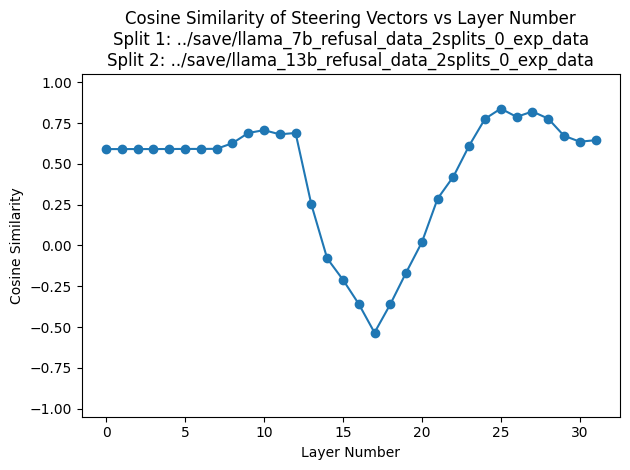

In [10]:
plot_all_cosine_similarity(first_dirpath, second_dirpath, layer_numbers)

CCA for layer: 0
CCA for layer: 1
CCA for layer: 2
CCA for layer: 3
CCA for layer: 4
CCA for layer: 5
CCA for layer: 6
CCA for layer: 7
CCA for layer: 8
CCA for layer: 9
CCA for layer: 10
CCA for layer: 11
CCA for layer: 12
CCA for layer: 13
CCA for layer: 14
CCA for layer: 15
CCA for layer: 16
CCA for layer: 17
CCA for layer: 18
CCA for layer: 19
CCA for layer: 20
CCA for layer: 21
CCA for layer: 22
CCA for layer: 23
CCA for layer: 24
CCA for layer: 25
CCA for layer: 26
CCA for layer: 27
CCA for layer: 28
CCA for layer: 29
CCA for layer: 30
CCA for layer: 31


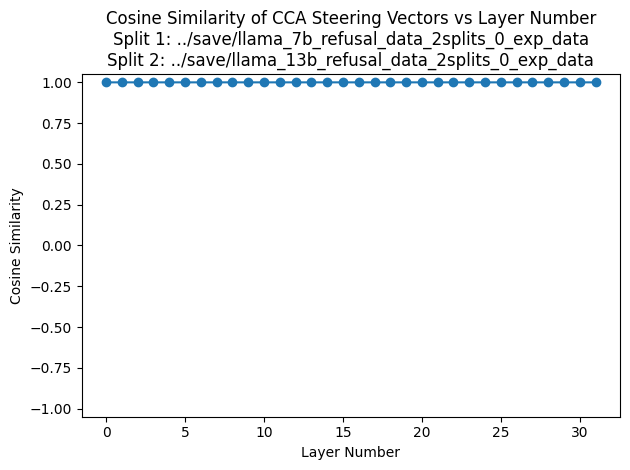

In [11]:
plot_all_cca_values(first_dirpath, second_dirpath, layer_numbers)

In [12]:
plot_all_dcca_values(first_dirpath, second_dirpath, layer_numbers)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


DCCA for layer: 0


/opt/miniconda3/envs/sparenv/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/miniconda3/envs/sparenv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/opt/miniconda3/envs/sparenv/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/opt/miniconda3/envs/sparenv/lib/python3.11/site-packages/pytorch_lightning/traine

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
/opt/miniconda3/envs/sparenv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test/objective         -34.60239791870117
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
DCCA for layer: 1


/opt/miniconda3/envs/sparenv/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test/objective         -34.74623107910156
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
DCCA for layer: 2


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test/objective         -34.724510192871094
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
DCCA for layer: 3


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test/objective         -34.56698989868164
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
DCCA for layer: 4


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test/objective         -34.65503692626953
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
DCCA for layer: 5


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test/objective         -34.83893966674805
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
DCCA for layer: 6


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test/objective         -34.64396286010742
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
DCCA for layer: 7


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test/objective         -34.58649444580078
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
DCCA for layer: 8


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test/objective         -34.54315185546875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
DCCA for layer: 9


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test/objective         -34.51483917236328
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
DCCA for layer: 10


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test/objective         -34.62077713012695
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
DCCA for layer: 11


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test/objective         -34.61075210571289
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
DCCA for layer: 12


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test/objective         -34.364967346191406
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
DCCA for layer: 13


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test/objective         -34.42524719238281
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
DCCA for layer: 14


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test/objective         -34.39218521118164
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
DCCA for layer: 15


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test/objective         -34.283668518066406
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
DCCA for layer: 16


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test/objective         -34.492557525634766
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
DCCA for layer: 17


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test/objective         -34.70820999145508
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
DCCA for layer: 18


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test/objective         -34.701499938964844
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
DCCA for layer: 19


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test/objective         -34.682823181152344
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
DCCA for layer: 20


Training: |          | 0/? [00:00<?, ?it/s]

_LinAlgError: linalg.svd: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated singular values (error code: 23).